# Data Paths and Prep

In [219]:
import importlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
import sklearn.manifold as sklm
import os
from sklearn.decomposition import PCA
import scanpy as sc
import functions
importlib.reload(functions)
functions.set_user('Laila')

In [220]:
data = functions.call_data_clean()
ATAC = data['ATAC_seq']
RNA = data['RNA_seq']
QC = data['QC_metrics']
ATAC_scores = data['norm_scores']
ATACtest = data['test1']

# Data Clean up and Normalization
---

### Check Data Sets after cleaning

In [221]:
# qc metrics
print(f"NaN in QC-metrics data set: {QC.isna().sum().sum()}")

# ATAC-seq
    # check for inf values
ATAC_inf = ATAC.isin([np.inf, -np.inf]).sum()
print(f"Infinite values in ATAC_seq: {ATAC_inf[ATAC_inf > 0].sum()}")

    # check for NaN values
print(f"NaN in ATAC_seq data set: {ATAC.isna().sum().sum()}")

print(len(QC))
print(len(ATAC.columns))
#print(ATAC)
#print(ATACtest.columns)
#print(ATACtest.index)
#print(ATACtest)
print(ATACtest.index[:10])
print(ATACtest.columns)
exons = data['exons']

NaN in QC-metrics data set: 5
Infinite values in ATAC_seq: 0
NaN in ATAC_seq data set: 760901
181
97
Index(['ImmGenATAC1219.peak_1', 'ImmGenATAC1219.peak_2',
       'ImmGenATAC1219.peak_3', 'ImmGenATAC1219.peak_4',
       'ImmGenATAC1219.peak_5', 'ImmGenATAC1219.peak_6',
       'ImmGenATAC1219.peak_7', 'ImmGenATAC1219.peak_8',
       'ImmGenATAC1219.peak_9', 'ImmGenATAC1219.peak_10'],
      dtype='object', name='ImmGenATAC1219.peakID')
Index(['chrom', 'Summit', 'mm10.60way.phastCons_scores', '_-log10_bestPvalue',
       'Included.in.systematic.analysis', 'TSS', 'genes.within.100Kb',
       'LTHSC.34-.BM', 'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM',
       'proB.CLP.BM', 'proB.FrA.BM', 'proB.FrBC.BM', 'preB.FrD.BM', 'B.FrE.BM',
       'B1b.PC', 'B.T1.Sp', 'B.T2.Sp', 'B.T3.Sp', 'B.Sp', 'B.Fem.Sp',
       'B.MZ.Sp', 'B.Fo.Sp', 'B.mem.Sp', 'B.GC.CB.Sp', 'B.GC.CC.Sp', 'B.PB.Sp',
       'B.PC.Sp', 'B.PC.BM', 'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th',
       'preT.DN3.Th', 'T.DN4.Th'

In [222]:
exons
print(ATAC['chrom'].unique())

['chr1' 'chr10' 'chr11' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16' 'chr17'
 'chr18' 'chr19' 'chr1_GL456210_random' 'chr1_GL456211_random'
 'chr1_GL456212_random' 'chr1_GL456221_random' 'chr2' 'chr3' 'chr4'
 'chr4_GL456216_random' 'chr4_JH584292_random' 'chr4_JH584295_random'
 'chr5' 'chr6' 'chr7' 'chr8' 'chr9' 'chrUn_GL456239' 'chrUn_GL456359'
 'chrUn_GL456366' 'chrUn_GL456368' 'chrUn_GL456370' 'chrUn_GL456372'
 'chrUn_GL456378' 'chrUn_GL456383' 'chrUn_GL456387' 'chrUn_GL456389'
 'chrUn_GL456390' 'chrUn_GL456392' 'chrUn_GL456393' 'chrUn_GL456396'
 'chrUn_JH584304' 'chrX' 'chrX_GL456233_random' 'chrY']


# Exploratory Data
---

### Variance of peak signal

In [231]:
from scipy.spatial import cKDTree
exons['TSS'] = np.where(exons['Strand'] == '+',
                        exons['Transcription Start'],
                        exons['Transcription End'])
distance_list = []
gene_list = []

for chrom in ATAC['chrom'].unique():
    print(f"Verarbeite Chromosom: {chrom}")

    # Peaks auf diesem Chrom
    peaks_chr = ATAC[ATAC['chrom'] == chrom]
    peaks_pos = peaks_chr['Summit'].values

    # TSS-Koordinaten und Gen-Namen auf diesem Chrom
    exons_chr = exons[exons['Chromosom'] == chrom]
    tss_pos = exons_chr['TSS'].values
    gene_names = exons_chr['Genname'].values

    if len(tss_pos) > 0:
        # KDTree
        tree = cKDTree(tss_pos.reshape(-1, 1))
        dist, idx = tree.query(peaks_pos.reshape(-1, 1), k=1)

        distance_list.extend(dist)
        gene_list.extend(gene_names[idx])
    else:
        distance_list.extend([np.nan] * len(peaks_pos))
        gene_list.extend([np.nan] * len(peaks_pos))

ATAC_dis = ATAC.copy()
ATAC_dis['nearest_gene'] = gene_list
ATAC_dis['distance_to_TSS'] = distance_list
ATAC_dis['mean'] = ATAC_scores.mean(axis=1, numeric_only=True)
ATAC_dis['median'] = ATAC_scores.median(axis=1, numeric_only=True)
ATAC_dis['var'] = ATAC_scores.var(axis=1, numeric_only=True)
ATAC_dis['sd'] = ATAC_scores.std(axis=1, numeric_only=True)
ATAC_dis['variability'] = ATAC_dis['sd'] / (ATAC_dis['mean'] + 1e-6)
ATAC_dis['min'] = ATAC_scores.min(axis=1)
ATAC_dis['max'] = ATAC_scores.max(axis=1)
ATAC_dis['range'] = ATAC_dis['max'] - ATAC_dis['min']
ATAC_dis['skewness'] = ATAC_scores.apply(scipy.stats.skew, axis=1)
ATAC_dis['region_type'] = np.where(ATAC_dis['distance_to_TSS'].abs() < 300, 'Promoter', 'Enhancer')

#ATAC_scores = ATAC_dis.iloc[:,7:89]

#ATAC_dis = ATAC_dis[
    #(ATAC_dis['mean'] <= 5) &
    #(ATAC_dis['sd'] <= 2) &
    #(ATAC_dis['variability'] <= 2) &
    #(ATAC_dis['distance_to_TSS'].abs() <= 300)
#]
#print(ATAC_dis[['chrom', 'Summit', 'distance_to_TSS', 'nearest_gene']].head())

Verarbeite Chromosom: chr1
Verarbeite Chromosom: chr10
Verarbeite Chromosom: chr11
Verarbeite Chromosom: chr12
Verarbeite Chromosom: chr13
Verarbeite Chromosom: chr14
Verarbeite Chromosom: chr15
Verarbeite Chromosom: chr16
Verarbeite Chromosom: chr17
Verarbeite Chromosom: chr18
Verarbeite Chromosom: chr19
Verarbeite Chromosom: chr1_GL456210_random
Verarbeite Chromosom: chr1_GL456211_random
Verarbeite Chromosom: chr1_GL456212_random
Verarbeite Chromosom: chr1_GL456221_random
Verarbeite Chromosom: chr2
Verarbeite Chromosom: chr3
Verarbeite Chromosom: chr4
Verarbeite Chromosom: chr4_GL456216_random
Verarbeite Chromosom: chr4_JH584292_random
Verarbeite Chromosom: chr4_JH584295_random
Verarbeite Chromosom: chr5
Verarbeite Chromosom: chr6
Verarbeite Chromosom: chr7
Verarbeite Chromosom: chr8
Verarbeite Chromosom: chr9
Verarbeite Chromosom: chrUn_GL456239
Verarbeite Chromosom: chrUn_GL456359
Verarbeite Chromosom: chrUn_GL456366
Verarbeite Chromosom: chrUn_GL456368
Verarbeite Chromosom: chrUn_

In [228]:
# var, mean etc. per peak
variability_per_peak = ATAC_dis['sd']/ATAC_dis['mean']
range_per_peak = ATAC_scores.max(axis=1)-ATAC_scores.min(axis=1)

# within cell type
range_per_celltype = ATAC_scores.max()-ATAC_scores.min()
mean_per_celltype = ATAC_scores.mean()
variance_per_celltype = ATAC_scores.var(axis = 0, numeric_only = True)

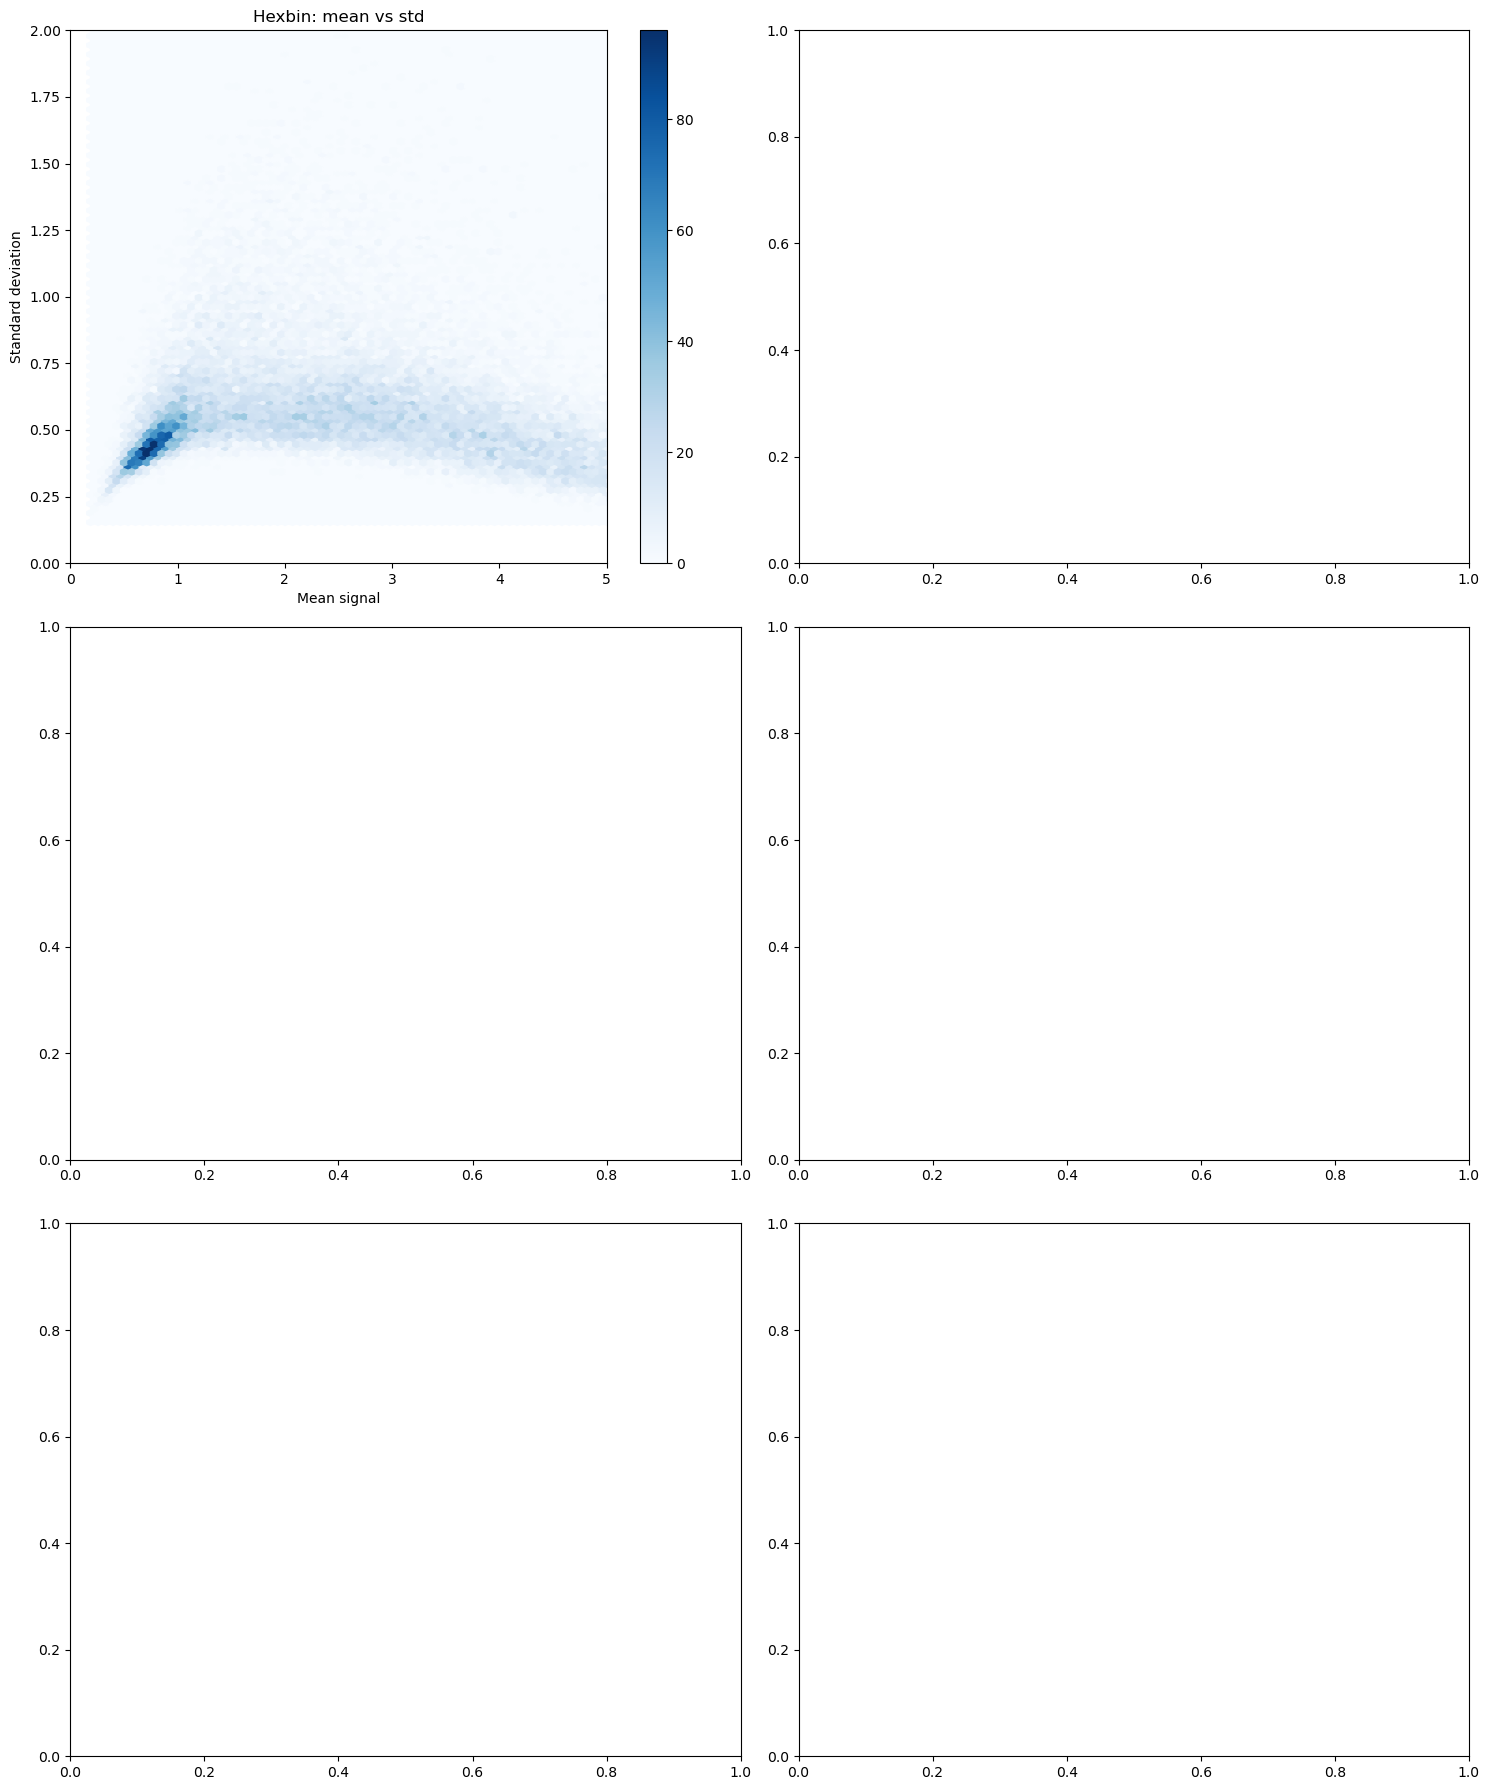

In [229]:
fig, axs = plt.subplots(3, 2, figsize=(15, 18))
hb1 = axs[0, 0].hexbin(ATAC_dis['mean'], ATAC_dis['sd'], gridsize=100, cmap="Blues")
axs[0,0].set_xlim(0,5)
axs[0,0].set_ylim(0,2)
axs[0, 0].set_xlabel("Mean signal")
axs[0, 0].set_ylabel("Standard deviation")
axs[0, 0].set_title("Hexbin: mean vs std")
fig.colorbar(hb1, ax=axs[0, 0])
plt.tight_layout()
plt.show()

KeyError: 'distance_to_TSS'

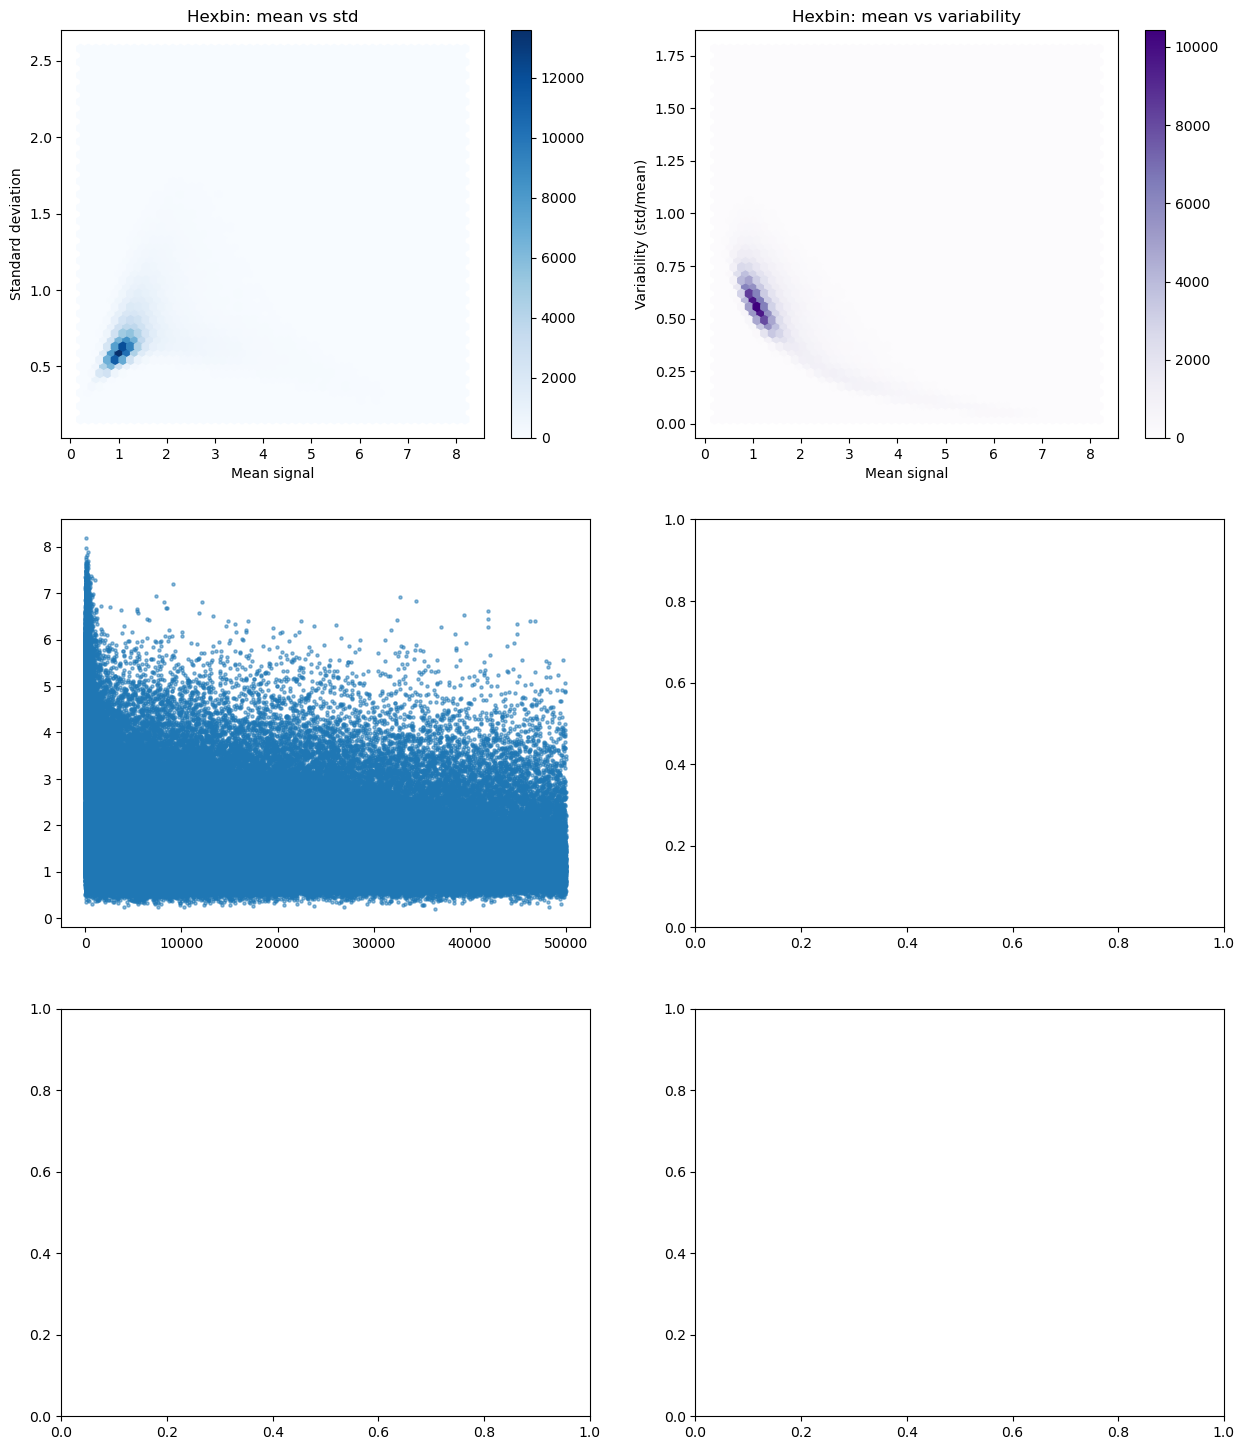

In [168]:
fig, axs = plt.subplots(3, 2, figsize=(15, 18))

## Plot 1: hexbin mean vs std
hb1 = axs[0, 0].hexbin(mean_per_peak, sd_per_peak, gridsize=50, cmap="Blues")
axs[0, 0].set_xlabel("Mean signal")
axs[0, 0].set_ylabel("Standard deviation")
axs[0, 0].set_title("Hexbin: mean vs std")
fig.colorbar(hb1, ax=axs[0, 0])

## Plot 2: hexbin mean vs variability
hb2 = axs[0, 1].hexbin(mean_per_peak, variability_per_peak, gridsize=50, cmap="Purples")
axs[0, 1].set_xlabel("Mean signal")
axs[0, 1].set_ylabel("Variability (std/mean)")
axs[0, 1].set_title("Hexbin: mean vs variability")
fig.colorbar(hb2, ax=axs[0, 1])

## Plot 3: scatter distance to TSS vs mean
axs[1, 0].scatter(ATAC_dis['distance_to_TSS'], mean_per_peak, s=5, alpha=0.5)
sns.regplot(x='distance_to_TSS', y=mean_per_peak, data=ATAC, scatter=False, lowess=True, ax=axs[1, 0], color="red")
axs[1, 0].set_xlabel("Distance to TSS (bp)")
axs[1, 0].set_ylabel("Mean signal")
axs[1, 0].set_title("Scatter: distance to TSS vs mean signal")

## Plot 4: hexbin distance to TSS vs mean
hb3 = axs[1, 1].hexbin(ATAC_dis['distance_to_TSS'], mean_per_peak, gridsize=100, cmap="Greens")
axs[1, 1].set_xlabel("Distance to TSS (bp)")
axs[1, 1].set_ylabel("Mean signal")
axs[1, 1].set_title("Hexbin: distance to TSS vs mean")
fig.colorbar(hb3, ax=axs[1, 1])

## Plot 5: histogram of distance to TSS
axs[2, 0].hist(ATAC_dis['distance_to_TSS'].dropna(), bins=100, color="steelblue")
axs[2, 0].set_xlabel("Distance to TSS (bp)")
axs[2, 0].set_ylabel("Peak count")
axs[2, 0].set_title("Histogram: distance to TSS")

## Plot 6: barplot mean signal per celltype
axs[2, 1].bar(mean_per_celltype.index, mean_per_celltype.values, color="teal")
axs[2, 1].set_xticklabels(mean_per_celltype.index, rotation=90)
axs[2, 1].set_ylabel("Mean ATAC-signal")
axs[2, 1].set_title("Mean signal per cell type")

plt.tight_layout()
plt.show()


# Discriptive and Comparative Analysis

# Statistical Analysis and Regression Models

In [31]:
ATAC_w_info = data['ATAC_seq_w_info']

print(ATAC_w_info)

ATAC_w_info[ATAC_w_info.isna().any(axis=1)]

                           CellType ImmGenATAC1219.peak_1  \
0                             chrom                  chr1   
1                            Summit               3020786   
2       mm10.60way.phastCons_scores                   0.0   
3                _-log10_bestPvalue                  0.56   
4   Included.in.systematic.analysis                         
..                              ...                   ...   
92                          FRC.SLN              1.182692   
93                          IAP.SLN              0.137504   
94                          BEC.SLN              0.650765   
95                          LEC.SLN              2.094236   
96                      Ep.MEChi.Th              1.269033   

   ImmGenATAC1219.peak_2 ImmGenATAC1219.peak_3 ImmGenATAC1219.peak_4  \
0                   chr1                  chr1                  chr1   
1                3087226               3120109               3121485   
2                    0.0                  0.07     

,CellType,ImmGenATAC1219.peak_1,ImmGenATAC1219.peak_2,ImmGenATAC1219.peak_3,ImmGenATAC1219.peak_4,ImmGenATAC1219.peak_5,ImmGenATAC1219.peak_6,ImmGenATAC1219.peak_7,ImmGenATAC1219.peak_8,ImmGenATAC1219.peak_9,...,ImmGenATAC1219.peak_512589,ImmGenATAC1219.peak_512590,ImmGenATAC1219.peak_512591,ImmGenATAC1219.peak_512592,ImmGenATAC1219.peak_512593,ImmGenATAC1219.peak_512594,ImmGenATAC1219.peak_512595,Lineage,CellFamily,Organ
0,chrom,chr1,chr1,chr1,chr1,chr1,chr1,chr1,chr1,chr1,...,chrY,chrY,chrY,chrY,chrY,chrY,chrY,NaN,NaN,NaN
1,Summit,3020786,3087226,3120109,3121485,3372787,3399217,3400115,3416260,3434092,...,90811728,90812084,90812450,90812906,90813175,90813624,90828985,NaN,NaN,NaN
2,mm10.60way.phastCons_scores,0.0,0.0,0.07,0.15,0.03,0.06,0.44,0.01,0.18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
3,_-log10_bestPvalue,0.56,0.5,10.8,3.02,1.31,2.39,2.57,2.57,1.34,...,2.33,3.12,3.99,3.21,0.69,0.6,1.41,NaN,NaN,NaN
4,Included.in.systematic.analysis,,,1,1,,1,1,1,,...,1,1,1,1,,,,NaN,NaN,NaN
5,TSS,,,,,,,,,,...,,,,,,,,NaN,NaN,NaN
6,genes.within.100Kb,,,,,,,,,,...,Erdr1,Erdr1,Erdr1,Erdr1,Erdr1,Erdr1,Erdr1,NaN,NaN,NaN
7,LTHSC.34-.BM,0.495695,0.495695,1.748461,0.495695,0.495695,1.748461,0.495695,1.748461,2.424922,...,0.495695,1.748461,2.424922,0.495695,0.495695,0.495695,0.495695,NaN,NaN,NaN
8,LTHSC.34+.BM,0.773996,1.400538,0.137504,0.137504,0.137504,1.400538,0.137504,0.773996,0.137504,...,3.072106,3.291309,3.291309,3.072106,0.773996,1.400538,0.773996,NaN,NaN,NaN
9,STHSC.150-.BM,0.925999,0.925999,0.925999,0.15056,0.15056,1.510962,0.15056,0.925999,0.925999,...,1.510962,0.925999,2.176323,2.176323,0.15056,0.15056,0.925999,NaN,NaN,NaN
